<a href="https://colab.research.google.com/github/shreyab1111/MultiLexNorm-Challenge/blob/main/Danish/da_ln_seq2seq_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

Danish

In [5]:
batch_size = 64  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
num_samples = 20000  # Number of samples to train on.
data_path = '/content/drive/MyDrive/NLP/Lexical Normalisation/Multilexnorm Challenge/Danish/da.train.norm.txt'

Character encoding

In [6]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r") as f:
    lines = f.readlines()
for line in lines[: min(num_samples, len(lines) - 1)]:
  if line=='\n':
    continue
  else:
    input_text, target_text= line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 9392
Number of unique input tokens: 152
Number of unique output tokens: 154
Max sequence length for inputs: 32
Max sequence length for outputs: 35


In [7]:
input_texts

['jeg',
 'er',
 'træt',
 'af',
 'GoT',
 ',',
 'jeg',
 'synes',
 'ikke',
 'Tyrion',
 'er',
 'sjov',
 'længere',
 ',',
 'jeg',
 'synes',
 'Daenaerys',
 'er',
 'meget',
 'mindre',
 'klog',
 'og',
 'sej',
 'end',
 'hun',
 'plejede',
 'at',
 'være',
 ',',
 'og',
 'jeg',
 'kan',
 'ikke',
 'komme',
 'mig',
 'over',
 'at',
 'The',
 'White',
 'Walkers',
 'bare',
 'var',
 'en',
 'plotdevice',
 'for',
 'at',
 'sætte',
 'hende',
 'ligeligt',
 'op',
 'mod',
 'Cersei',
 '-',
 'og',
 'Euron',
 'som',
 'jeg',
 'ikke',
 'magter',
 '…',
 'https://t.co/7l1DsA5dRG',
 'Valget',
 'Indefra',
 ':',
 'LA-profil',
 'i',
 'shitstorm',
 'efter',
 'forsøg',
 'på',
 'at',
 'være',
 'sjov',
 'om',
 'sine',
 'hængebryster',
 'Forhadt',
 'socialdemokratisk',
 'kandidat',
 'er',
 'blevet',
 'reddet',
 'af',
 'teknikaliteter',
 ',',
 'mens',
 'Liberal',
 'Alliance',
 'er',
 'gået',
 'i',
 'det',
 'lumre',
 'hjørne',
 '.',
 'Velkommen',
 'til',
 'Valget',
 'Indefra',
 '.',
 'https://t.co/Ew08bs813L',
 'Markante',
 'kreds

encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.

decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [8]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

one hot rep

In [9]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[',']] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, (t + 1):, target_token_index[',']] = 1.0
    decoder_target_data[i, t:, target_token_index[',']] = 1.0

In [10]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [11]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/150
118/118 [==============================] - 13s 42ms/step - loss: 0.8588 - accuracy: 0.8248 - val_loss: 0.5809 - val_accuracy: 0.8563
Epoch 2/150
118/118 [==============================] - 4s 35ms/step - loss: 0.5523 - accuracy: 0.8585 - val_loss: 0.4762 - val_accuracy: 0.8640
Epoch 3/150
118/118 [==============================] - 4s 34ms/step - loss: 0.4571 - accuracy: 0.8800 - val_loss: 0.4027 - val_accuracy: 0.8928
Epoch 4/150
118/118 [==============================] - 4s 34ms/step - loss: 0.4078 - accuracy: 0.8903 - val_loss: 0.3684 - val_accuracy: 0.9009
Epoch 5/150
118/118 [==============================] - 4s 34ms/step - loss: 0.3701 - accuracy: 0.9001 - val_loss: 0.3323 - val_accuracy: 0.9114
Epoch 6/150
118/118 [==============================] - 4s 34ms/step - loss: 0.3428 - accuracy: 0.9066 - val_loss: 0.3271 - val_accuracy: 0.9110
Epoch 7/150
118/118 [==============================] - 4s 33ms/step - loss: 0.3229 - accuracy: 0.9112 - val_loss: 0.3021 - val_accuracy

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


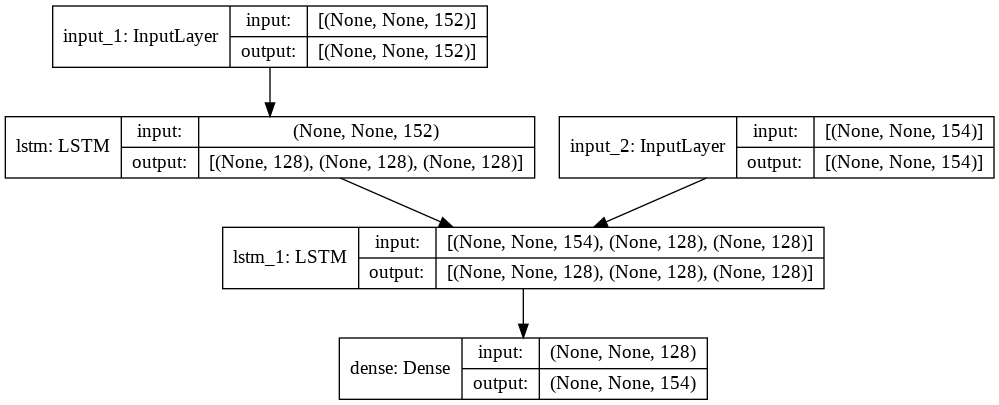

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

testing with validation

In [13]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_6")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_5")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [17]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: jeg
Decoded sentence: jeg

-
Input sentence: er
Decoded sentence: er

-
Input sentence: træt
Decoded sentence: træt

-
Input sentence: af
Decoded sentence: af

-
Input sentence: GoT
Decoded sentence: GoT

-
Input sentence: ,
Decoded sentence: ,

-
Input sentence: jeg
Decoded sentence: jeg

-
Input sentence: synes
Decoded sentence: synes

-
Input sentence: ikke
Decoded sentence: ikke

-
Input sentence: Tyrion
Decoded sentence: Tyrion

-
Input sentence: er
Decoded sentence: er

-
Input sentence: sjov
Decoded sentence: sjov

-
Input sentence: længere
Decoded sentence: længere

-
Input sentence: ,
Decoded sentence: ,

-
Input sentence: jeg
Decoded sentence: jeg

-
Input sentence: synes
Decoded sentence: synes

-
Input sentence: Daenaerys
Decoded sentence: Daenaerys

-
Input sentence: er
Decoded sentence: er

-
Input sentence: meget
Decoded sentence: meget

-
Input sentence: mindre
Decoded sentence: mindre

-
Input sentence: klog
Decoded sentence: klog

-
Input sentence: o